<a href="https://colab.research.google.com/github/bees4ever/ai-workshop-2022/blob/main/Custom_Training_YOLO_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone 'https://github.com/Shenggan/BCCD_Dataset.git'

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800
Receiving objects: 100% (800/800), 7.39 MiB | 7.53 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [2]:
!wget https://github.com/bees4ever/ai-workshop-2022/blob/main/yolo_sample/custom_yolo_masked_person_poc_all_v05.zip?raw=true -O custom_yolo_masked_person_poc_all_v05.zip
!unzip custom_yolo_masked_person_poc_all_v05.zip


--2022-10-20 14:57:54--  https://github.com/bees4ever/ai-workshop-2022/blob/main/yolo_sample/custom_yolo_masked_person_poc_all_v05.zip?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/bees4ever/ai-workshop-2022/raw/main/yolo_sample/custom_yolo_masked_person_poc_all_v05.zip [following]
--2022-10-20 14:57:54--  https://github.com/bees4ever/ai-workshop-2022/raw/main/yolo_sample/custom_yolo_masked_person_poc_all_v05.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bees4ever/ai-workshop-2022/main/yolo_sample/custom_yolo_masked_person_poc_all_v05.zip [following]
--2022-10-20 14:57:54--  https://raw.githubusercontent.com/bees4ever/ai-workshop-2022/main/yolo_sample/custom_yolo_masked_person_poc_all_v05.zip
Resolving raw.githubusercontent.c

#**DATA PRE-PROCESSING STARTS**

# Extraction of data labels from .xml file to dataframe

In [3]:
import shutil
import os, sys, random
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile
import pandas as pd
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np
import os

In [4]:
annotations = sorted(glob('/content/custom_yolo_masked_person_poc_all_v05/labels/*.xml'))

df = []
cnt = 0
for file in annotations:
  prev_filename = file.split('/')[-1].split('.')[0] + '.jpeg'
  filename = str(cnt) + '.jpg'
  row = []
  parsedXML = ET.parse(file)
  img_width = int(float(parsedXML.getroot().find('size/width').text))
  img_height = int(float(parsedXML.getroot().find('size/height').text))

  for node in parsedXML.getroot().iter('object'):
    blood_cells = node.find('name').text
    xmin = int(float(node.find('bndbox/xmin').text))
    xmax = int(float(node.find('bndbox/xmax').text))
    ymin = int(float(node.find('bndbox/ymin').text))
    ymax = int(float(node.find('bndbox/ymax').text))

    row = [prev_filename, filename, blood_cells, xmin, xmax, ymin, ymax, img_width, img_height]
    df.append(row)
  cnt += 1

data = pd.DataFrame(df, columns=['prev_filename', 'filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax', 'img_width', 'img_height'])

data[['prev_filename','filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax','img_width', 'img_height']].to_csv('/content/custom_yolo_masked_person.csv', index=False)


# Processing data as per the YOLO_V5 format

**DATAFRAME STRUCTURE**

- filename : contains the name of the image
- cell_type: denotes the type of the cell
- xmin: x-coordinate of the bottom left part of the image
- xmax: x-coordinate of the top right part of the image
- ymin: y-coordinate of the bottom left part of the image
- ymax: y-coordinate of the top right part of the image
- labels : Encoded cell-type **(Yolo - label input-1)**
- width : width of that bbox
- height : height of that bbox
- x_center : bbox center (x-axis)
-	y_center : bbox center (y-axis)
-	x_center_norm	: x_center normalized (0-1) **(Yolo - label input-2)**
-	y_center_norm : y_center normalized (0-1) **(Yolo - label input-3)**
- width_norm : width normalized (0-1) **(Yolo - label input-4)**
-	height_norm : height normalized (0-1) **(Yolo - label input-5)**

In [5]:
df = pd.read_csv('/content/custom_yolo_masked_person.csv')
df.head(30)

,prev_filename,filename,cell_type,xmin,xmax,ymin,ymax,img_width,img_height
0,abbas-malek-hosseini-JC1oue4zY5U-unsplash.jpeg,0.jpg,Person,0,632,231,1064,640,1067
1,aditya-saxena-01R4fryNgUM-unsplash.jpeg,1.jpg,Masked,3,632,44,998,640,1005
2,adrien-king-amn3wfTkU_c-unsplash.jpeg,2.jpg,Person,161,496,394,956,640,959
3,ahmed-firdaus-N7HRLjqNDqg-unsplash.jpeg,3.jpg,Person,183,512,167,953,640,960
4,albert-dera-ILip77SbmOE-unsplash.jpeg,4.jpg,Masked,1,637,8,955,640,960
5,alex-geerts-_4CqNN233S0-unsplash.jpeg,5.jpg,Person,231,315,164,295,640,427
6,alexandru-zdrobau-BGz8vO3pK8k-unsplash.jpeg,6.jpg,Person,24,634,10,952,640,963
7,allen-taylor-0cmJRW5rOJ8-unsplash.jpeg,7.jpg,Person,298,407,496,862,640,960
8,allen-taylor-0cmJRW5rOJ8-unsplash.jpeg,7.jpg,Person,370,448,570,845,640,960
9,allen-taylor-0cmJRW5rOJ8-unsplash.jpeg,7.jpg,Person,111,208,570,896,640,960


In [6]:
#img_width = 640
#img_height = 480

def width(df):
  return int(df.xmax - df.xmin)
def height(df):
  return int(df.ymax - df.ymin)
def x_center(df):
  return int(df.xmin + (df.width/2))
def y_center(df):
  return int(df.ymin + (df.height/2))

df = pd.read_csv('/content/custom_yolo_masked_person.csv')

le = preprocessing.LabelEncoder()
le.fit(df['cell_type'])
print(le.classes_)
labels = le.transform(df['cell_type'])
df['labels'] = labels

df['width'] = df.apply(width, axis=1)
df['height'] = df.apply(height, axis=1)

df['x_center'] = df.apply(x_center, axis=1)
df['y_center'] = df.apply(y_center, axis=1)

df['x_center_norm'] = df['x_center']/df.img_width
df['width_norm'] = df['width']/df.img_width

df['y_center_norm'] = df['y_center'] / df.img_height
df['height_norm'] = df['height']/ df.img_height

df.head(30)

['Masked' 'Person']


,prev_filename,filename,cell_type,xmin,xmax,ymin,ymax,img_width,img_height,labels,width,height,x_center,y_center,x_center_norm,width_norm,y_center_norm,height_norm
0,abbas-malek-hosseini-JC1oue4zY5U-unsplash.jpeg,0.jpg,Person,0,632,231,1064,640,1067,1,632,833,316,647,0.493750,0.987500,0.606373,0.780694
1,aditya-saxena-01R4fryNgUM-unsplash.jpeg,1.jpg,Masked,3,632,44,998,640,1005,0,629,954,317,521,0.495312,0.982812,0.518408,0.949254
2,adrien-king-amn3wfTkU_c-unsplash.jpeg,2.jpg,Person,161,496,394,956,640,959,1,335,562,328,675,0.512500,0.523438,0.703858,0.586027
3,ahmed-firdaus-N7HRLjqNDqg-unsplash.jpeg,3.jpg,Person,183,512,167,953,640,960,1,329,786,347,560,0.542188,0.514062,0.583333,0.818750
4,albert-dera-ILip77SbmOE-unsplash.jpeg,4.jpg,Masked,1,637,8,955,640,960,0,636,947,319,481,0.498437,0.993750,0.501042,0.986458
5,alex-geerts-_4CqNN233S0-unsplash.jpeg,5.jpg,Person,231,315,164,295,640,427,1,84,131,273,229,0.426563,0.131250,0.536300,0.306792
6,alexandru-zdrobau-BGz8vO3pK8k-unsplash.jpeg,6.jpg,Person,24,634,10,952,640,963,1,610,942,329,481,0.514062,0.953125,0.499481,0.978193
7,allen-taylor-0cmJRW5rOJ8-unsplash.jpeg,7.jpg,Person,298,407,496,862,640,960,1,109,366,352,679,0.550000,0.170313,0.707292,0.381250
8,allen-taylor-0cmJRW5rOJ8-unsplash.jpeg,7.jpg,Person,370,448,570,845,640,960,1,78,275,409,707,0.639062,0.121875,0.736458,0.286458
9,allen-taylor-0cmJRW5rOJ8-unsplash.jpeg,7.jpg,Person,111,208,570,896,640,960,1,97,326,159,733,0.248438,0.151562,0.763542,0.339583


prev_filename    ana-itonishvili-_meIjZYso8M-unsplash.jpeg
filename                                            10.jpg
cell_type                                           Masked
xmin                                                     2
xmax                                                   335
ymin                                                     0
ymax                                                   426
img_width                                              640
img_height                                             427
labels                                                   0
width                                                  333
height                                                 426
x_center                                               168
y_center                                               213
x_center_norm                                       0.2625
width_norm                                        0.520312
y_center_norm                                     0.4988

NameError: ignored

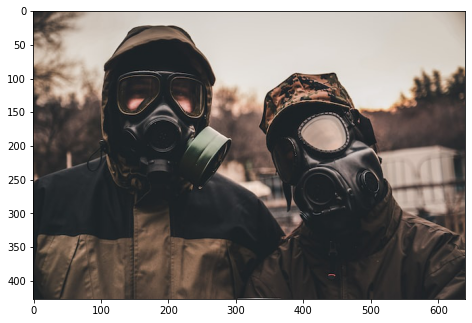

In [10]:
#@title SAMPLE PLOT - shape (480, 640, 3)
fig = plt.figure()
import cv2
#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('/content/custom_yolo_masked_person_poc_all_v05/images/ana-itonishvili-_meIjZYso8M-unsplash.jpeg')
plt.imshow(image)

# iterating over the image for different objects
for _,row in df[df.prev_filename == "ana-itonishvili-_meIjZYso8M-unsplash.jpeg"].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin
    print(row)
    # assign different color to different classes of objects
    if row.cell_type == 'Person':
        edgecolor = 'r'
        ax.annotate('Person', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'Criminal':
        edgecolor = 'b'
        ax.annotate('Criminal', xy=(xmax-40,ymin+20))

        
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

# Splitting into training and validation datasets

In [11]:
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=13, shuffle=True)
print(df_train.shape, df_valid.shape)

(295, 18) (33, 18)


In [12]:
os.mkdir('/content/custom_masked_person/')
os.mkdir('/content/custom_masked_person/images/')
os.mkdir('/content/custom_masked_person/images/train/')
os.mkdir('/content/custom_masked_person/images/valid/')

os.mkdir('/content/custom_masked_person/labels/')
os.mkdir('/content/custom_masked_person/labels/train/')
os.mkdir('/content/custom_masked_person/labels/valid/')

# Data segregation and moving to it's corresponding folders
- BCC
  - Images
    - Train (364 images [.jpg files])
    - Valid (270 images [.jpg files])
  - Labels
    - Train (364 labels [.txt files])
    - Valid (270 labels [.txt files])


**STRUCTURE OF .txt FILE**

- One row per object
- Each row is class x_center y_center width height format.
- Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes  are in pixels, divide x_center and width by image width, and y_center and height by image height.
- Class numbers are zero-indexed (start from 0).


<img src="https://github.com/bala-codes/Yolo-v5_Object_Detection_Blood_Cell_Count_and_Detection/blob/master/imgs/label_txt.PNG?raw=true" width="50%">


In [13]:
def segregate_data(df, img_path, train_img_path, train_label_path):
  filenames = []
  for filename in df.filename:
    filenames.append(filename)
  filenames = set(filenames)
  
  for filename in filenames:
    yolo_list = []

    for _,row in df[df.filename == filename].iterrows():
      yolo_list.append([row.labels, row.x_center_norm, row.y_center_norm, row.width_norm, row.height_norm])

    yolo_list = np.array(yolo_list)
    print(os.path.join(train_label_path,str(row.prev_filename.split('.')[0])+".txt"))
    txt_filename = os.path.join(train_label_path,str(row.prev_filename.split('.')[0])+".txt")
    # Save the .img & .txt files to the corresponding train and validation folders
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])
    shutil.copyfile(os.path.join(img_path,row.prev_filename), os.path.join(train_img_path,row.prev_filename))

In [14]:
%%time
src_img_path = "/content/custom_yolo_masked_person_poc_all_v05/images"

train_img_path = "/content/custom_masked_person/images/train/"
train_label_path = "/content/custom_masked_person/labels/train/"


valid_img_path = "/content/custom_masked_person/images/valid"
valid_label_path = "/content/custom_masked_person/labels/valid"

segregate_data(df_train, src_img_path, train_img_path, train_label_path)
segregate_data(df_valid, src_img_path, valid_img_path, valid_label_path)

/content/custom_masked_person/labels/train/microsoft-365-nhBYukjZg_I-unsplash.txt
/content/custom_masked_person/labels/train/pexels-simon-reza-12040411.txt
/content/custom_masked_person/labels/train/nata-figueiredo-8qrnOP1s6H4-unsplash.txt
/content/custom_masked_person/labels/train/pexels-alena-darmel-6643598.txt
/content/custom_masked_person/labels/train/aditya-saxena-01R4fryNgUM-unsplash.txt
/content/custom_masked_person/labels/train/dasha-blankovaya-WKZRYGGQmR4-unsplash.txt
/content/custom_masked_person/labels/train/allen-taylor-0cmJRW5rOJ8-unsplash.txt
/content/custom_masked_person/labels/train/rochelle-brown-OOrrYFUVfdk-unsplash.txt
/content/custom_masked_person/labels/train/courtney-coles-flaI6lisU9k-unsplash.txt
/content/custom_masked_person/labels/train/andre-ouellet-FzECg2eNhj4-unsplash.txt
/content/custom_masked_person/labels/train/pexels-caleb-oquendo-3018088.txt
/content/custom_masked_person/labels/train/mustafa-omar-WQUWCcDO8uI-unsplash.txt
/content/custom_masked_person/la

In [16]:
try:
  shutil.rmtree('/content/bcc/images/train/.ipynb_checkpoints')
except FileNotFoundError:
  pass

try:
  shutil.rmtree('/content/bcc/images/valid/.ipynb_checkpoints')
except FileNotFoundError:
  pass

try:
  shutil.rmtree('/content/bcc/labels/train/.ipynb_checkpoints')
except FileNotFoundError:
  pass

try:
  shutil.rmtree('/content/bcc/labels/valid/.ipynb_checkpoints')
except FileNotFoundError:
  pass

print("No. of Training images", len(os.listdir(train_img_path)))
print("No. of Training labels", len(os.listdir(train_label_path)))

print("No. of valid images", len(os.listdir(valid_img_path)))
print("No. of valid labels", len(os.listdir(valid_label_path)))

No. of Training images 181
No. of Training labels 181
No. of valid images 32
No. of valid labels 32


# **END OF DATA PRE-PROCESSING**

#**YOLO V5 STARTS**

In [17]:
!mkdir -p '/content/drive/My Drive/Machine Learning Projects/YOLO/'
!cp -r '/content/custom_masked_person' '/content/drive/My Drive/Machine Learning Projects/YOLO/'

# Cloning from the yolo v5 repo.
More can be found at here : [yolo](https://github.com/ultralytics/yolov5)

In [19]:
!git clone  'https://github.com/ultralytics/yolov5.git'

Cloning into 'yolov5'...
remote: Enumerating objects: 14298, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 14298 (delta 62), reused 65 (delta 31), pack-reused 14194
Receiving objects: 100% (14298/14298), 13.39 MiB | 18.31 MiB/s, done.
Resolving deltas: 100% (9877/9877), done.


In [20]:
!pip install -qr '/content/yolov5/requirements.txt'  # install dependencies

     |████████████████████████████████| 1.6 MB 47.2 MB/s 


# WE SHOULD CREATE A .yaml FILE AND THEN PLACE IT INSIDE THE yolov5 FOLDER

#**Contents of YAML file**

train: /content/custom_masked_person/images/train                    
val: /content/custom_masked_person/images/valid

nc: 2

names: ['Masked', 'Person']


In [21]:
!rm 'custom_yolo_masked_person.yaml'
!echo -e 'train: /content/custom_masked_person/images/train\nval: /content/custom_masked_person/images/valid\n\nnc: 2\nnames: ['Masked', 'Person']' >> custom_yolo_masked_person.yaml
!cat 'custom_yolo_masked_person.yaml'

rm: cannot remove 'custom_yolo_masked_person.yaml': No such file or directory
train: /content/custom_masked_person/images/train
val: /content/custom_masked_person/images/valid

nc: 2
names: [Masked, Person]


In [22]:
shutil.copyfile('/content/custom_yolo_masked_person.yaml', '/content/yolov5/custom_yolo_masked_person.yaml')

'/content/yolov5/custom_yolo_masked_person.yaml'

#**Also edit the number of classes (nc) in the ./models/*.yaml file**

Choose the yolo model of your choice, here I chose yolov5s.yaml (yolo - small)


In [23]:
!sed -i 's/nc: 80/nc: 2/g' ./yolov5/models/yolov5s.yaml

# Training command

**Training Parameters**

!python 
- <'location of train.py file'> 
- --img <'width of image'>
- --batch <'batch size'>
- --epochs <'no of epochs'>
- --data <'location of the .yaml file'>
- --cfg <'Which yolo configuration you want'>(yolov5s/yolov5m/yolov5l/yolov5x).yaml | (small, medium, large, xlarge)
- --name <'Name of the best model after training'>

**METRICS FROM TRAINING PROCESS**

**No.of classes, No.of images, No.of targets, Precision (P), Recall (R), mean Average Precision (map)**
- Class | Images | Targets | P | R | mAP@.5 | mAP@.5:.95: |
- all   | 270    |     489 |    0.0899 |       0.827 |      0.0879 |      0.0551

In [ ]:
%%time

!python yolov5/train.py --img 640 --batch 1 --epochs 200 --data yolov5/custom_yolo_masked_person.yaml --cfg yolov5/models/yolov5s.yaml --name CriminalDetection

train: weights=yolov5/yolov5s.pt, cfg=yolov5/models/yolov5s.yaml, data=yolov5/custom_yolo_masked_person.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=CriminalDetection, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-203-g6371de8 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0,

In [ ]:
# Start tensorboard (optional)
%load_ext tensorboard
%tensorboard --logdir yolov5/runs/

#**INFERENCE**

In [ ]:
#Optimizer stripped from runs/exp2_BCCM/weights/last_BCCM.pt, 14.8MB
#Optimizer stripped from runs/exp2_BCCM/weights/best_BCCM.pt, 14.8MB

# BATCH PREDICTION
- Results saved to inference/output


**Inference Parameters**

!python 
- <'location of detect.py file'> 
- --source <'location of image/ folder to predict'>
- --weight <'location of the saved best weights'>
- --output <'location of output files after prediction'>

In [ ]:
!python yolov5/detect.py --source /content/custom_masked_person/images/valid/ --weights '/content/yolov5/runs/train/CriminalDetection/weights/best.pt' 

In [ ]:
!python yolov5/detect.py --source /content/prepared_done --weights '/content/yolov5/runs/train/CriminalDetection/weights/best.pt' 

In [ ]:
!python yolov5/detect.py --source /content/custom_yolo_masked_person_poc_all_v04/images/ --weights '/content/yolov5/runs/train/CriminalDetection/weights/best.pt' 

In [ ]:
!unzip prepared_done.zip

In [ ]:
disp_images = glob('/content/yolov5/runs/detect/exp9/*')
fig=plt.figure(figsize=(20*5, 28*5))
columns = 3
rows = 40
for i in range(1, columns*rows +1):
    img = np.random.choice(disp_images)
    img = plt.imread(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# SINGLE IMAGE PREDICTIONS


In [ ]:
output = !python yolov5/detect.py --source /content/custom_yolo_masked_person_v01/images/valid/dave-spiess-QevEgXYHpzs-unsplash.jpeg --weights '/content/yolov5/runs/train/CriminalDetection/weights/best.pt'
print(output)

# You need these files, if you wish to move the model to production

## Files

In [ ]:
shutil.copyfile('/content/yolov5/detect.py', '/content/drive/My Drive/Machine Learning Projects/YOLO/SOURCE/detect.py')
shutil.copyfile('/content/yolov5/requirements.txt', '/content/drive/My Drive/Machine Learning Projects/YOLO/SOURCE/requirements.txt')
shutil.copyfile('/content/runs/exp2_BCCM/weights/best_BCCM.pt', '/content/drive/My Drive/Machine Learning Projects/YOLO/SOURCE/best_BCCM.pt')



## Folder

In [ ]:
!cp -r '/content/yolov5/models' '/content/drive/My Drive/Machine Learning Projects/YOLO/SOURCE/'
!cp -r '/content/yolov5/utils' '/content/drive/My Drive/Machine Learning Projects/YOLO/SOURCE/'
